In [1]:
import pandas as pd
import numpy as np
import os
os.chdir("D:\\diệu ổ D\\MBS\\model_predict_who_mr_loan_next_m\\version_2\\Data")


df_base = pd.read_csv("base_margin_data_t10.csv")
df_metric = pd.read_csv("score_metric_data_t10.csv")
df_base= pd.merge(df_base, df_metric, on='master_account', how='inner')

df_base = df_base.drop(columns = ['loan_label_next'])

In [2]:
import pandas as pd
import numpy as np

# 1. Nhóm các biến chỉ có giá trị dương (Cần chặn trên 99%)
pos_cols = [
    'turnover_12m', 'flow_ratio_12m',
    'flow_ratio_3m','order_buy_ratio_3m', 'order_buy_ratio_12m', 'order_sell_ratio_3m', 'order_sell_ratio_12m',
    'Trading_Intensity_Surge', 'login_trend', 'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m', 'trading_count_12m',
    'trading_count_3m', "buy_intensity_3m"
]

# 2. Nhóm các biến có giá trị âm (Cần chặn cả 2 đầu: 1% và 99%)
# Đặc biệt quan trọng cho Beta, Alpha, Profit, Net Flow
two_way_cols = [
    'profit_ratio_3m',
    'cash_flow_3m', 'cash_flow_12m', 
    'buy_sell_pressure_3m', 'buy_sell_pressure_12m',
    'order_buy_sell_pressure_3m', 'beta_2w', 'alpha_2w', 'drawdown_2w', 'Cash_Drag_Ratio_3m', 'Cash_Drag_Ratio_12m', #'buy_intensity_negative_3m'
]

def handle_outliers(df):
    df_capped = df.copy()
    
    # Xử lý nhóm chặn trên 0.99
    for col in pos_cols:
        if col in df_capped.columns:
            upper_limit = df_capped[col].quantile(0.99)
            df_capped[col] = df_capped[col].clip(upper=upper_limit)
            
    # Xử lý nhóm chặn 2 đầu (0.01 và 0.99)
    for col in two_way_cols:
        if col in df_capped.columns:
            lower_limit = df_capped[col].quantile(0.01)
            upper_limit = df_capped[col].quantile(0.99)
            df_capped[col] = df_capped[col].clip(lower=lower_limit, upper=upper_limit)
            
    return df_capped

# Áp dụng
df_base = handle_outliers(df_base)

In [3]:
df_pred = pd.read_csv("margin_pred.csv")

df_pred.pred.value_counts()

pred
0    48542
1    13307
Name: count, dtype: int64

In [4]:


# 2. Chuẩn hoá tên cột master_account trong cả 2 df (thay đổi nếu tên khác)
# Nếu cột df đã có 'master_account' thì giữ, nếu không tìm các tên phổ biến và rename
def find_master_col(d):
    for c in ['master_account','master_acc','account','account_id','master']:
        if c in d.columns:
            return c
    return None

pred_master = find_master_col(df_pred)
data_master = find_master_col(df_base)

if pred_master is None:
    raise KeyError("Không tìm thấy cột master_account trong df_pred.")
if data_master is None:
    raise KeyError("Không tìm thấy cột master_account trong df_base.")

# rename về cùng tên 'master_account' để dễ thao tác
if pred_master != 'master_account':
    df_pred = df_pred.rename(columns={pred_master: 'master_account'})
if data_master != 'master_account':
    df_base = df_base.rename(columns={data_master: 'master_account'})

# strip whitespace, đảm bảo kiểu string
df_pred['master_account'] = df_pred['master_account'].astype(str).str.strip()
df_base['master_account'] = df_base['master_account'].astype(str).str.strip()
# 3. Tìm master_account có pred == 1 trong df_pred
pred_col_candidates = [c for c in df_pred.columns if c.lower() in ('pred','prediction','y_pred','label')]
pred_col = pred_col_candidates[0] if pred_col_candidates else None
if pred_col is None:
    raise KeyError("Không tìm thấy cột pred (nhãn dự đoán) trong df_pred. Đổi tên cột sang 'pred' hoặc 'prediction'.")

positives = df_pred.loc[df_pred[pred_col] == 0, 'master_account'].unique().tolist()
print(f"Số master_account có pred==0 trong df_pred: {len(positives)}")

# 4A. Option 1 - Chỉ lọc df, giữ nguyên các cột của df
df_filtered = df_base[df_base['master_account'].isin(positives)].copy()
print(f"Số hàng trong df sau khi filter (chỉ giữ các master_account có pred==0): {len(df_filtered)}")
df_filtered.to_csv("df_filtered_by_pred0.csv", index=False)
print("Saved df_filtered_by_pred0.csv (giữ nguyên cột df)")

# 4B. Option 2 - Lọc và map thêm thông tin pred/prob từ df_pred vào df (nếu muốn)
# Nếu df_pred có nhiều dòng cho cùng master_account, bạn có thể chọn:
#  - giữ bản ghi có prob lớn nhất (nếu df_pred có cột prob)
#  - hoặc giữ bản ghi mới nhất theo timestamp (nếu df_pred có timestamp)
# Dưới đây: nếu có cột 'prob' sẽ chọn bản ghi có prob lớn nhất; nếu không, drop_duplicates giữ bản đầu.

prob_col = None
for c in ['prob','pred_proba','proba','probability','score']:
    if c in df_pred.columns:
        prob_col = c
        break

if prob_col:
    df_pred_sub = df_pred.sort_values(by=prob_col, ascending=False).drop_duplicates(subset=['master_account'])
else:
    # fallback: chỉ drop duplicates giữ bản đầu
    df_pred_sub = df_pred.drop_duplicates(subset=['master_account'])

# rename master col in df_pred_sub to match
# (đã rename lên 'master_account' ở trên)
# Chỉ lấy cột master_account + pred (+ prob nếu có)
keep_cols = ['master_account', pred_col]
if prob_col:
    keep_cols.append(prob_col)
df_pred_sub = df_pred_sub[keep_cols]

# Merge (inner) để chỉ lấy các master_account có pred==1, và thêm cột pred/prob vào df
df_merged = df_base.merge(df_pred_sub, on='master_account', how='inner')





Số master_account có pred==0 trong df_pred: 48515
Số hàng trong df sau khi filter (chỉ giữ các master_account có pred==0): 48642
Saved df_filtered_by_pred0.csv (giữ nguyên cột df)


In [5]:
df_filtered.shape

(48642, 60)

In [6]:
df = df_filtered.copy() 
df = df.drop(columns=['pred'], errors='ignore')  
if 'master_account' in df.columns:
    df.set_index('master_account', inplace=True)

print(f"Kích thước dữ liệu đầu vào: {df.shape}")

Kích thước dữ liệu đầu vào: (48642, 59)


In [7]:
df.columns

Index(['customer_category', 'Age', 'open_date', 'months_since_open',
       'avg_nav_cash_12m', 'avg_nav_ck_12m', 'total_trading_amount_12m',
       'total_cash_in_12m', 'total_cash_out_12m', 'trading_count_12m',
       'login_count_12m', 'nav_ck_start_12m', 'nav_ck_end_12m',
       'unique_shares_12m', 'order_buy_12m', 'order_sell_12m', 'total_buy_12m',
       'total_sell_12m', 'avg_nav_cash_3m', 'avg_nav_ck_3m',
       'total_trading_amount_3m', 'total_cash_in_3m', 'total_cash_out_3m',
       'trading_count_3m', 'login_count_3m', 'nav_ck_start_3m',
       'nav_ck_end_3m', 'unique_shares_3m', 'order_buy_3m', 'order_sell_3m',
       'total_buy_3m', 'total_sell_3m', 'avg_nav_cash_2w', 'avg_nav_ck_2w',
       'total_trading_amount_2w', 'total_cash_in_2w', 'total_cash_out_2w',
       'trading_count_2w', 'login_count_2w', 'nav_ck_start_2w',
       'nav_ck_end_2w', 'unique_shares_2w', 'order_buy_2w', 'order_sell_2w',
       'total_buy_2w', 'total_sell_2w', 'profit_value_12m', 'profit_ratio_

In [8]:
#(Tỷ lệ tiền mặt/Tổng tài sản):

df['Cash_Drag_Ratio_3m'] = df['avg_nav_cash_3m'] / (df['avg_nav_ck_3m'] + df['avg_nav_cash_3m'])
df['Cash_Drag_Ratio_12m'] = df['avg_nav_cash_12m'] / (df['avg_nav_ck_12m'] + df['avg_nav_cash_12m'])



# (Bùng nổ giao dịch)
#df['Trading_Intensity_Surge'] = df['trading_count_3m']/(df['trading_count_12m'] / 4)
df['Trading_Intensity_Surge'] = df['trading_count_3m'] / df['trading_count_12m']


df['asset_allocation_stock_ratio_3m'] = df['avg_nav_ck_3m'] / (df['avg_nav_ck_3m'] + df['avg_nav_cash_3m'])
df['asset_allocation_stock_ratio_12m'] = df['avg_nav_ck_12m'] / (df['avg_nav_ck_12m'] + df['avg_nav_cash_12m'])

#df['net_flow_trend'] = df['net_cash_flow_3m'] - (df['net_cash_flow_12m'] / 4)

#df['order_buy_sell_pressure_3m'] = df['order_buy_3m'] / (df['order_sell_3m'] + 1e-6)
#df['is_loss_chasing'] = ((df['profit_ratio_3m'] < 0) & (df['trading_count_3m'] > df['trading_count_12m']/4)).astype(int)


df['net_buy_pressure_3m'] = (df['order_buy_3m'] - df['order_sell_3m']) / (df['order_buy_3m'] + df['order_sell_3m'])




In [9]:
df = df[['alpha_2w','beta_2w','drawdown_2w',
         'buy_intensity_3m','buy_intensity_negative_3m',
         'Cash_Drag_Ratio_3m']]


In [10]:
cols_train = ['alpha_2w','beta_2w','drawdown_2w',
              'buy_intensity_3m','buy_intensity_negative_3m',
              'Cash_Drag_Ratio_3m']
df = df[cols_train]

In [11]:
import pandas as pd

import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import IsolationForest

from sklearn.cluster import KMeans



# --- B1: Chuẩn hóa dữ liệu ---

X = df.select_dtypes(include=[np.number])

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)



# --- B2: Lọc outlier bằng Isolation Forest ---

iso = IsolationForest(

    contamination=0.1,  # % dữ liệu coi là outlier, bạn có thể tune 0.01–0.05

    random_state=42

)

outlier_pred = iso.fit_predict(X_scaled)



# chỉ giữ lại điểm bình thường (label = 1)

mask = outlier_pred == 1

X_clean = X_scaled[mask]

df_clean = df[mask].copy()



print(f"Sau khi lọc còn {len(df_clean)} / {len(df)} quan sát")



# --- B3: Phân cụm bằng KMeans ---

kmeans = KMeans(n_clusters=4, random_state=42, n_init=50)

df_clean['Cluster'] = kmeans.fit_predict(X_clean)



print(df_clean['Cluster'].value_counts())



# --- B4: Gán label vào toàn bộ df (outlier = -1) ---

df['Cluster'] = -1

df.loc[mask, 'Cluster'] = df_clean['Cluster']

Sau khi lọc còn 43777 / 48642 quan sát
Cluster
0    15438
3    12094
1     9963
2     6282
Name: count, dtype: int64


In [12]:
# --- B3: Phân cụm bằng KMeans (Chạy nháp trước) ---
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=4, random_state=42, n_init=50)
# Lưu tạm vào biến temp
df_clean['Cluster_Temp'] = kmeans.fit_predict(X_clean)

# --- B3.5: Sắp xếp lại Label về đúng số cố định (0, 1, 2, 3) ---
# Bước này cực quan trọng để đảm bảo Cluster 1 luôn là VIP, Cluster 0 luôn là Risk...
# Tính trung bình để nhận diện các nhóm
stats = df_clean.groupby('Cluster_Temp')[['buy_intensity_3m', 'alpha_2w']].mean()

# Tìm ID hiện tại của từng nhóm dựa trên đặc tính cốt lõi:
# 1. Nhóm VIP (Cluster 1): Là nhóm có buy_intensity cao nhất
id_vip = stats['buy_intensity_3m'].idxmax()

# 2. Nhóm Smart (Cluster 3): Là nhóm có alpha cao nhất (dương)
id_smart = stats['alpha_2w'].idxmax()

# 3. Nhóm Risk (Cluster 0): Là nhóm có alpha thấp nhất (âm sâu nhất)
id_risk = stats['alpha_2w'].idxmin()

# 4. Nhóm Mass (Cluster 2): Là nhóm còn lại
all_ids = set(stats.index)
id_mass = list(all_ids - {id_vip, id_smart, id_risk})[0]

# Tạo map để đổi số: ID_Temp -> ID_Cố_định
# Quy ước như bạn mong muốn: Risk=0, VIP=1, Mass=2, Smart=3
mapping_dict = {
    id_risk: 0,
    id_vip: 1,
    id_mass: 2,
    id_smart: 3
}

# Áp dụng map vào df_clean
df_clean['Cluster'] = df_clean['Cluster_Temp'].map(mapping_dict)
# Xóa cột temp cho gọn
df_clean.drop(columns=['Cluster_Temp'], inplace=True)

# Kiểm tra lại số lượng (Phải khớp: 2->4678, 3->3595, 0->2038, 1->1689)
print("Số lượng quan sát trong từng Cluster sau khi cố định:")
print(df_clean['Cluster'].value_counts().sort_index())

# --- B4: Gán label vào toàn bộ df gốc (Outlier = -1) ---
df['Cluster'] = -1
df.loc[mask, 'Cluster'] = df_clean['Cluster']

# Kiểm tra kết quả cuối cùng trên DF gốc
print("\nPhân bổ Cluster trên toàn bộ dữ liệu:")
print(df['Cluster'].value_counts())

Số lượng quan sát trong từng Cluster sau khi cố định:
Cluster
0    12094
1    15438
2     6282
3     9963
Name: count, dtype: int64

Phân bổ Cluster trên toàn bộ dữ liệu:
Cluster
 1    15438
 0    12094
 3     9963
 2     6282
-1     4865
Name: count, dtype: int64


In [13]:
final_mapping = df[['Cluster']].reset_index()

# 2. Đổi tên cột cho chuẩn (nếu cần)
# Giả sử index của bạn tên là 'master_account', sau khi reset nó sẽ thành cột 'master_account'
final_mapping.columns = ['master_account', 'Cluster']

# 3. Kiểm tra kết quả
print("Kích thước bảng mapping:", final_mapping.shape)
print(final_mapping.head())

Kích thước bảng mapping: (48642, 2)
  master_account  Cluster
0         000009        0
1         000012        0
2         000014        0
3         000020        0
4         000021       -1


In [14]:
# Chỉ lấy các cột số để tính toán cho từng cụm
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Group by Cluster và xem giá trị trung bình (thường dùng Mean để thấy sự khác biệt)
cluster_analysis = df.groupby('Cluster')[numeric_cols].mean()

# Hiển thị bảng kết quả
print("Đặc điểm trung bình của từng nhóm:")
display(cluster_analysis)

# Nếu muốn xem chi tiết (min, max, std...), dùng describe:
for cluster_id in sorted(df['Cluster'].unique()):
    print(f"\n--- Thống kê chi tiết cho Nhóm {cluster_id} ---")
    display(df[df['Cluster'] == cluster_id][numeric_cols].describe())

Đặc điểm trung bình của từng nhóm:


,alpha_2w,beta_2w,drawdown_2w,buy_intensity_3m,buy_intensity_negative_3m,Cash_Drag_Ratio_3m,Cluster
Cluster,,,,,,,
-1,-0.020089,0.711529,-0.075489,4.244506,1.957549,0.255347,-1.0
0,-0.051994,0.928863,-0.062606,0.775350,0.281093,0.088093,0.0
1,0.028406,0.893050,-0.022203,0.848795,0.320678,0.095591,1.0
2,0.042127,0.295043,-0.013424,0.557865,0.178484,0.620537,2.0
3,0.076573,0.269690,-0.014587,0.608462,0.154108,0.090390,3.0



--- Thống kê chi tiết cho Nhóm -1 ---


,alpha_2w,beta_2w,drawdown_2w,buy_intensity_3m,buy_intensity_negative_3m,Cash_Drag_Ratio_3m,Cluster
count,4865.000000,4865.000000,4865.000000,4865.000000,4865.000000,4865.000000,4865.0
mean,-0.020089,0.711529,-0.075489,4.244506,1.957549,0.255347,-1.0
std,0.120081,0.644093,0.075535,4.607119,2.961105,0.320148,0.0
min,-0.278656,-0.192172,-0.283755,0.000000,0.000000,-0.943134,-1.0
25%,-0.114577,0.145049,-0.127015,1.031161,0.000000,0.006180,-1.0
50%,-0.014142,0.659267,-0.048725,3.129771,1.219182,0.146783,-1.0
75%,0.052982,1.091818,-0.015520,5.561690,2.816665,0.471890,-1.0
max,0.230673,2.607375,0.000000,21.232314,39.956332,0.999307,-1.0



--- Thống kê chi tiết cho Nhóm 0 ---


,alpha_2w,beta_2w,drawdown_2w,buy_intensity_3m,buy_intensity_negative_3m,Cash_Drag_Ratio_3m,Cluster
count,12094.000000,12094.000000,12094.000000,12094.000000,12094.000000,12094.000000,12094.0
mean,-0.051994,0.928863,-0.062606,0.775350,0.281093,0.088093,0.0
std,0.026482,0.256100,0.021297,1.022312,0.501785,0.122357,0.0
min,-0.160499,-0.192172,-0.201539,0.000000,0.000000,-0.312433,0.0
25%,-0.069645,0.793813,-0.072695,0.000000,0.000000,0.004461,0.0
50%,-0.048674,0.979283,-0.058334,0.334135,0.000000,0.037264,0.0
75%,-0.035576,1.058257,-0.047165,1.230255,0.358963,0.135841,0.0
max,0.118573,2.607375,-0.009276,7.936925,3.315570,0.701232,0.0



--- Thống kê chi tiết cho Nhóm 1 ---


,alpha_2w,beta_2w,drawdown_2w,buy_intensity_3m,buy_intensity_negative_3m,Cash_Drag_Ratio_3m,Cluster
count,15438.000000,15438.000000,15438.000000,15438.000000,15438.000000,15438.000000,15438.0
mean,0.028406,0.893050,-0.022203,0.848795,0.320678,0.095591,1.0
std,0.041409,0.226158,0.011030,1.092446,0.517240,0.113401,0.0
min,-0.065093,0.263102,-0.093570,0.000000,0.000000,-0.423943,1.0
25%,-0.002378,0.739777,-0.029195,0.000000,0.000000,0.009784,1.0
50%,0.019681,0.881933,-0.020713,0.442162,0.043506,0.054579,1.0
75%,0.050810,1.017558,-0.014152,1.264907,0.449354,0.154990,1.0
max,0.230673,2.607375,0.000000,10.321053,3.551217,0.652774,1.0



--- Thống kê chi tiết cho Nhóm 2 ---


,alpha_2w,beta_2w,drawdown_2w,buy_intensity_3m,buy_intensity_negative_3m,Cash_Drag_Ratio_3m,Cluster
count,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.0
mean,0.042127,0.295043,-0.013424,0.557865,0.178484,0.620537,2.0
std,0.034193,0.283318,0.015089,0.896573,0.368062,0.182536,0.0
min,-0.074594,-0.192172,-0.102593,0.000000,0.000000,0.317021,2.0
25%,0.023095,0.009649,-0.020031,0.000000,0.000000,0.466983,2.0
50%,0.049846,0.249374,-0.008731,0.035031,0.000000,0.589882,2.0
75%,0.053094,0.497605,-0.000571,0.822951,0.179621,0.757928,2.0
max,0.230673,1.427589,0.000000,7.913374,2.450785,1.000000,2.0



--- Thống kê chi tiết cho Nhóm 3 ---


,alpha_2w,beta_2w,drawdown_2w,buy_intensity_3m,buy_intensity_negative_3m,Cash_Drag_Ratio_3m,Cluster
count,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.0
mean,0.076573,0.269690,-0.014587,0.608462,0.154108,0.090390,3.0
std,0.053183,0.273550,0.015936,1.154456,0.356560,0.124694,0.0
min,-0.037227,-0.192172,-0.131242,0.000000,0.000000,-6.115790,3.0
25%,0.049348,0.000475,-0.020538,0.000000,0.000000,0.009861,3.0
50%,0.055125,0.252694,-0.010894,0.062324,0.000000,0.053177,3.0
75%,0.094501,0.478408,-0.000592,0.726566,0.102988,0.157847,3.0
max,0.230673,1.074207,0.000000,8.714299,2.761440,0.451564,3.0


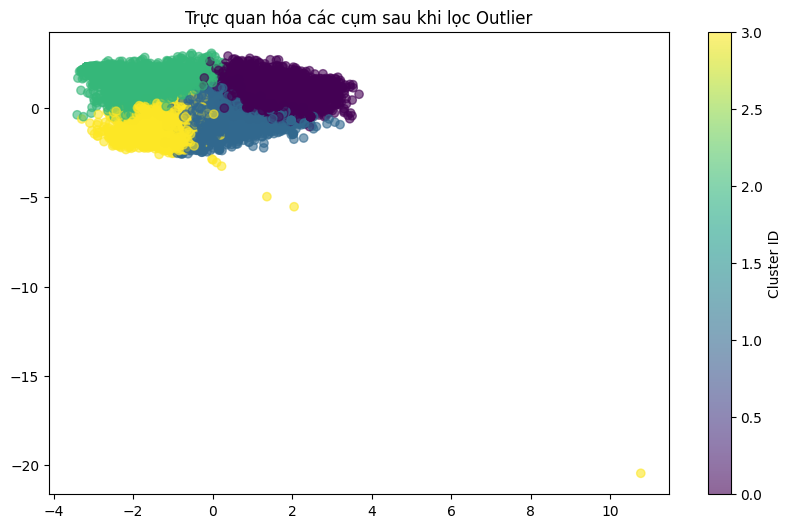

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clean)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_clean['Cluster'], cmap='viridis', marker='o', alpha=0.6)
plt.title('Trực quan hóa các cụm sau khi lọc Outlier')
plt.colorbar(label='Cluster ID')
plt.show()

In [16]:
# Xác định các cột tính toán (loại bỏ Cluster và các cột không phải số)
analysis_cols = df_clean.select_dtypes(include=[np.number]).columns

# 1. Xem bảng tổng hợp giá trị trung bình
cluster_summary = df_clean.groupby('Cluster')[analysis_cols].mean()
print("Giá trị trung bình của từng cụm:")
display(cluster_summary)

# 2. Xem chi tiết phân phối của từng nhóm (Quan trọng để tìm Insight)
for i in sorted(df_clean['Cluster'].unique()):
    print(f"\n--- Phân tích chi tiết Cluster {i} ---")
    # Hiển thị thống kê mô tả cho từng nhóm
    display(df_clean[df_clean['Cluster'] == i][analysis_cols].describe())

Giá trị trung bình của từng cụm:


,alpha_2w,beta_2w,drawdown_2w,buy_intensity_3m,buy_intensity_negative_3m,Cash_Drag_Ratio_3m,Cluster
Cluster,,,,,,,
0,-0.051994,0.928863,-0.062606,0.775350,0.281093,0.088093,0.0
1,0.028406,0.893050,-0.022203,0.848795,0.320678,0.095591,1.0
2,0.042127,0.295043,-0.013424,0.557865,0.178484,0.620537,2.0
3,0.076573,0.269690,-0.014587,0.608462,0.154108,0.090390,3.0



--- Phân tích chi tiết Cluster 0 ---


,alpha_2w,beta_2w,drawdown_2w,buy_intensity_3m,buy_intensity_negative_3m,Cash_Drag_Ratio_3m,Cluster
count,12094.000000,12094.000000,12094.000000,12094.000000,12094.000000,12094.000000,12094.0
mean,-0.051994,0.928863,-0.062606,0.775350,0.281093,0.088093,0.0
std,0.026482,0.256100,0.021297,1.022312,0.501785,0.122357,0.0
min,-0.160499,-0.192172,-0.201539,0.000000,0.000000,-0.312433,0.0
25%,-0.069645,0.793813,-0.072695,0.000000,0.000000,0.004461,0.0
50%,-0.048674,0.979283,-0.058334,0.334135,0.000000,0.037264,0.0
75%,-0.035576,1.058257,-0.047165,1.230255,0.358963,0.135841,0.0
max,0.118573,2.607375,-0.009276,7.936925,3.315570,0.701232,0.0



--- Phân tích chi tiết Cluster 1 ---


,alpha_2w,beta_2w,drawdown_2w,buy_intensity_3m,buy_intensity_negative_3m,Cash_Drag_Ratio_3m,Cluster
count,15438.000000,15438.000000,15438.000000,15438.000000,15438.000000,15438.000000,15438.0
mean,0.028406,0.893050,-0.022203,0.848795,0.320678,0.095591,1.0
std,0.041409,0.226158,0.011030,1.092446,0.517240,0.113401,0.0
min,-0.065093,0.263102,-0.093570,0.000000,0.000000,-0.423943,1.0
25%,-0.002378,0.739777,-0.029195,0.000000,0.000000,0.009784,1.0
50%,0.019681,0.881933,-0.020713,0.442162,0.043506,0.054579,1.0
75%,0.050810,1.017558,-0.014152,1.264907,0.449354,0.154990,1.0
max,0.230673,2.607375,0.000000,10.321053,3.551217,0.652774,1.0



--- Phân tích chi tiết Cluster 2 ---


,alpha_2w,beta_2w,drawdown_2w,buy_intensity_3m,buy_intensity_negative_3m,Cash_Drag_Ratio_3m,Cluster
count,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.000000,6282.0
mean,0.042127,0.295043,-0.013424,0.557865,0.178484,0.620537,2.0
std,0.034193,0.283318,0.015089,0.896573,0.368062,0.182536,0.0
min,-0.074594,-0.192172,-0.102593,0.000000,0.000000,0.317021,2.0
25%,0.023095,0.009649,-0.020031,0.000000,0.000000,0.466983,2.0
50%,0.049846,0.249374,-0.008731,0.035031,0.000000,0.589882,2.0
75%,0.053094,0.497605,-0.000571,0.822951,0.179621,0.757928,2.0
max,0.230673,1.427589,0.000000,7.913374,2.450785,1.000000,2.0



--- Phân tích chi tiết Cluster 3 ---


,alpha_2w,beta_2w,drawdown_2w,buy_intensity_3m,buy_intensity_negative_3m,Cash_Drag_Ratio_3m,Cluster
count,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.0
mean,0.076573,0.269690,-0.014587,0.608462,0.154108,0.090390,3.0
std,0.053183,0.273550,0.015936,1.154456,0.356560,0.124694,0.0
min,-0.037227,-0.192172,-0.131242,0.000000,0.000000,-6.115790,3.0
25%,0.049348,0.000475,-0.020538,0.000000,0.000000,0.009861,3.0
50%,0.055125,0.252694,-0.010894,0.062324,0.000000,0.053177,3.0
75%,0.094501,0.478408,-0.000592,0.726566,0.102988,0.157847,3.0
max,0.230673,1.074207,0.000000,8.714299,2.761440,0.451564,3.0


In [18]:
df_fn = pd.read_csv("df_result_fn_full.csv")

In [19]:
import pandas as pd

# 1. Chuẩn hóa cột khóa (master_account)
df_fn['master_account'] = df_fn['master_account'].astype(str).str.strip()
final_mapping['master_account'] = final_mapping['master_account'].astype(str).str.strip()

# 2. Merge df_fn với final_mapping để lấy thông tin cụm
# Dùng 'inner' để chỉ lấy những khách thực tế vay nhưng model đoán 0
result_fn_df = pd.merge(
    df_fn, 
    final_mapping[['master_account', 'Cluster']], 
    on='master_account', 
    how='inner'
)

# 3. Thống kê số lượng và tỷ trọng
summary_fn = result_fn_df['Cluster'].value_counts().reset_index()
summary_fn.columns = ['Cluster', 'So_Luong_FN']

# Tính tỷ lệ % đóng góp của từng Cluster vào tổng số lỗi FN
summary_fn['Ty_Le_Trong_FN (%)'] = (summary_fn['So_Luong_FN'] / summary_fn['So_Luong_FN'].sum() * 100).round(2)

# Sắp xếp theo số lượng giảm dần
summary_fn = summary_fn.sort_values(by='So_Luong_FN', ascending=False)

print("--- PHÂN BỔ LỖI BỎ SÓT (FN) THEO CLUSTER ---")
print(summary_fn)

# 4. Kết luận chi tiết dựa trên Cluster ID
if not summary_fn.empty:
    top_fn_cluster = int(summary_fn.iloc[0]['Cluster'])
    percentage = summary_fn.iloc[0]['Ty_Le_Trong_FN (%)']
    
    print(f"\n=> KẾT LUẬN: Mô hình bỏ sót khách hàng nhiều nhất ở Cluster {top_fn_cluster}.")
    print(f"   Nhóm này chiếm {percentage}% trên tổng số khách hàng bị dự báo nhầm là không vay.")
    
    # Gợi ý ý nghĩa dựa trên chân dung cụm
    interpretations = {
        0: "Đây là nhóm rủi ro (Risk). Việc bỏ sót có thể do mô hình thấy họ lỗ nên đoán không vay, nhưng thực tế họ vay để gồng lỗ.",
        1: "Đây là nhóm VIP. Bỏ sót ở đây gây THẤT THU DOANH THU lớn nhất vì họ có volume giao dịch cao.",
        2: "Đây là nhóm Đại trà (Mass). Sai số ở đây thường do dữ liệu nhiễu hoặc hành vi khách hàng không ổn định.",
        3: "Đây là nhóm Thông minh (Smart). Mô hình bỏ sót vì nhóm này rất kỷ luật, chỉ vay khi thời điểm thực sự chín muồi."
    }
    print(f"👉 Ý nghĩa: {interpretations.get(top_fn_cluster, 'Cụm chưa xác định.')}")
else:
    print("\n=> CẢNH BÁO: Không khớp được dữ liệu FN với bảng Mapping.")

--- PHÂN BỔ LỖI BỎ SÓT (FN) THEO CLUSTER ---
   Cluster  So_Luong_FN  Ty_Le_Trong_FN (%)
0        1         1373               37.88
1        0          853               23.53
2       -1          776               21.41
3        3          448               12.36
4        2          175                4.83

=> KẾT LUẬN: Mô hình bỏ sót khách hàng nhiều nhất ở Cluster 1.
   Nhóm này chiếm 37.88% trên tổng số khách hàng bị dự báo nhầm là không vay.
👉 Ý nghĩa: Đây là nhóm VIP. Bỏ sót ở đây gây THẤT THU DOANH THU lớn nhất vì họ có volume giao dịch cao.


In [20]:
import pandas as pd

# 1. Chuẩn hóa lại cột master_account
df_fn['master_account'] = df_fn['master_account'].astype(str).str.strip()
final_mapping['master_account'] = final_mapping['master_account'].astype(str).str.strip()

# --- BƯỚC 1: TÍNH TỬ SỐ (Số lượng trong tệp Target - TP) ---
# Merge để lấy Cluster cho tệp TP
df_target_cluster = pd.merge(
    df_fn, 
    final_mapping[['master_account', 'Cluster']], 
    on='master_account', 
    how='inner'
)
# Đếm số lượng TP theo từng Cluster
count_in_target = df_target_cluster['Cluster'].value_counts()

# --- BƯỚC 2: TÍNH MẪU SỐ (Tổng số lượng trong toàn hệ thống) ---
# Đếm tổng số khách hàng của từng Cluster trong master data
count_total = final_mapping['Cluster'].value_counts()

# --- BƯỚC 3: TỔNG HỢP VÀ TÍNH TỶ LỆ ---
# Tạo DataFrame so sánh
analysis = pd.DataFrame({
    'So_Luong_Trong_TP': count_in_target,
    'Tong_So_Luong_He_Thong': count_total
})

# Xử lý trường hợp NaN (nếu có Cluster nào không xuất hiện trong TP thì gán = 0)
analysis.fillna(0, inplace=True)

# Tính xác suất (Penetration Rate)
analysis['Xac_Suat_Vao_TP (%)'] = (analysis['So_Luong_Trong_TP'] / analysis['Tong_So_Luong_He_Thong'] * 100).round(2)

# Sắp xếp theo xác suất giảm dần (Quan trọng nhất)
analysis = analysis.sort_values(by='Xac_Suat_Vao_TP (%)', ascending=False)

# Thêm tên tiếng Việt cho dễ nhìn (Optional)
segment_map = {0: 'Risk', 1: 'VIP', 2: 'Mass', 3: 'Smart', -1: 'Outlier'}
analysis['Ten_Nhom'] = analysis.index.map(segment_map)

print("--- XÁC SUẤT KHÁCH HÀNG RƠI VÀO TỆP MỤC TIÊU (THEO CLUSTER) ---")
print(analysis[['Ten_Nhom', 'So_Luong_Trong_TP', 'Tong_So_Luong_He_Thong', 'Xac_Suat_Vao_TP (%)']])

# --- BƯỚC 4: KẾT LUẬN ---
top_cluster_id = analysis.index[0]
top_prob = analysis.iloc[0]['Xac_Suat_Vao_TP (%)']
top_name = analysis.iloc[0]['Ten_Nhom']

print(f"\n=> KẾT LUẬN QUAN TRỌNG:")
print(f"   Mặc dù về số lượng có thể nhóm khác đông hơn, nhưng nhóm **Cluster {top_cluster_id} ({top_name})**")
print(f"   có xác suất cao nhất là **{top_prob}%** khách hàng sẽ nằm trong tệp mục tiêu.")
print(f"   => Đây là nhóm 'nhạy' nhất với mô hình dự báo của bạn.")

--- XÁC SUẤT KHÁCH HÀNG RƠI VÀO TỆP MỤC TIÊU (THEO CLUSTER) ---
        Ten_Nhom  So_Luong_Trong_TP  Tong_So_Luong_He_Thong  \
Cluster                                                       
-1       Outlier                776                    4865   
 1           VIP               1373                   15438   
 0          Risk                853                   12094   
 3         Smart                448                    9963   
 2          Mass                175                    6282   

         Xac_Suat_Vao_TP (%)  
Cluster                       
-1                     15.95  
 1                      8.89  
 0                      7.05  
 3                      4.50  
 2                      2.79  

=> KẾT LUẬN QUAN TRỌNG:
   Mặc dù về số lượng có thể nhóm khác đông hơn, nhưng nhóm **Cluster -1 (Outlier)**
   có xác suất cao nhất là **15.95%** khách hàng sẽ nằm trong tệp mục tiêu.
   => Đây là nhóm 'nhạy' nhất với mô hình dự báo của bạn.


In [32]:
df_clean.columns

Index(['alpha_2w', 'beta_2w', 'drawdown_2w', 'buy_intensity_3m',
       'buy_intensity_negative_3m', 'Cash_Drag_Ratio_3m', 'Cluster'],
      dtype='object')

In [52]:
df_fp = pd.read_csv("fp_keys.csv")

df_tp = pd.read_csv("df_result_tp_full.csv")

df_fn = pd.read_csv("df_result_fn_full.csv")


df_tn = pd.read_csv("df_result_tn_full.csv")

In [45]:
import pandas as pd
import numpy as np
import shap
import pickle

# ==========================================================
# BƯỚC 0: LOAD MODEL & FEATURES (Giữ nguyên phần bạn đã có)
# ==========================================================
with open("lightgbm_optuna_best_model_recall_70.pkl", "rb") as f:
    lgb_model = pickle.load(f)

with open("feature_order_v1_recall_70.pkl", "rb") as f:
    feature_names = pickle.load(f)

# ==========================================================
# BƯỚC 1: XỬ LÝ LỖI THIẾU CỘT (FIX KEYERROR)
# ==========================================================

# 1. Lọc khách hàng mục tiêu
df_target = df_clean[df_clean['Cluster'].isin([0, 1, 2, 3])].copy()

# 2. Tạo tập X_target ban đầu từ các cột đang có
existing_cols = [c for c in feature_names if c in df_target.columns]
X_target = df_target[existing_cols].copy()

# 3. Tìm các cột bị thiếu
missing_cols = [c for c in feature_names if c not in df_target.columns]

if len(missing_cols) > 0:
    print(f"⚠️ Phát hiện {len(missing_cols)} cột thiếu. Đang bù đắp bằng giá trị 0...")
    # Tạo DataFrame chứa toàn cột 0 cho các biến bị thiếu
    zero_data = np.zeros((len(X_target), len(missing_cols)))
    df_missing = pd.DataFrame(zero_data, columns=missing_cols, index=X_target.index)
    
    # Ghép các cột thiếu vào X_target
    X_target = pd.concat([X_target, df_missing], axis=1)

# 4. QUAN TRỌNG NHẤT: Ép đúng thứ tự cột tuyệt đối theo feature_names
# Bước này giúp giải quyết triệt để lỗi mismatch index/order
X_target = X_target[feature_names]

# Làm sạch dữ liệu (NaN, Inf)
X_target = X_target.apply(pd.to_numeric, errors='coerce').fillna(0)
X_target.replace([np.inf, -np.inf], 0, inplace=True)

print(f"✅ X_target đã sẵn sàng với {X_target.shape[1]} cột, đúng thứ tự Model yêu cầu.")

# ==========================================================
# BƯỚC 2: TÍNH TOÁN SHAP (Bây giờ sẽ chạy bình thường)
# ==========================================================

explainer = shap.TreeExplainer(lgb_model)
print("🔄 Đang tính toán SHAP...")
shap_values_raw = explainer.shap_values(X_target)

# Xử lý format mảng SHAP
if isinstance(shap_values_raw, list):
    shap_values_full = shap_values_raw[1]
elif len(shap_values_raw.shape) == 3:
    shap_values_full = shap_values_raw[:, :, 1]
else:
    shap_values_full = shap_values_raw

# ==========================================================
# BƯỚC 3: TỔNG HỢP KẾT QUẢ
# ==========================================================
df_shap_matrix = pd.DataFrame(shap_values_full, index=X_target.index, columns=feature_cols)
# ... (Các bước Top_Positive/Negative tiếp theo giữ nguyên như code trước của bạn)

⚠️ Phát hiện 22 cột thiếu. Đang bù đắp bằng giá trị 0...
✅ X_target đã sẵn sàng với 28 cột, đúng thứ tự Model yêu cầu.
🔄 Đang tính toán SHAP...


c:\Users\Admin\.conda\envs\py39\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [56]:
check_all_c1.head()

,master_account,Cluster,trading_count_12m,unique_shares_12m,trading_count_3m,unique_shares_3m,alpha_2w,beta_2w,drawdown_2w,buy_intensity_3m,...,asset_allocation_stock_ratio_3m,asset_allocation_stock_ratio_12m,age_group,tenure_group,Top_Positive_Feature,Max_SHAP,Max_Feature_Value,Top_Negative_Feature,Min_SHAP,Min_Feature_Value
15,000051,1,0.273111,-0.030234,-0.018031,-0.006816,-0.167016,0.312688,-0.084083,-0.028877,...,-0.253827,-0.111607,0.039919,-0.130150,beta_2w,0.312688,0.668064,asset_allocation_stock_ratio_3m,-0.253827,0.0
16,000055,1,0.201504,-0.026677,-0.009374,-0.017385,-0.157292,0.875466,-0.099310,0.111046,...,-0.255532,-0.075052,0.028072,-0.098491,beta_2w,0.875466,1.31266,asset_allocation_stock_ratio_3m,-0.255532,0.0
21,000111,1,0.256495,-0.038218,-0.038038,-0.020560,-0.162399,0.427398,-0.093637,0.130803,...,-0.235620,-0.080158,0.029937,-0.120298,beta_2w,0.427398,0.818989,asset_allocation_stock_ratio_3m,-0.235620,0.0
23,000133,1,0.231805,-0.027038,0.042836,0.001779,-0.253212,0.420036,-0.081403,-0.116199,...,-0.267966,-0.106999,0.029063,-0.119884,beta_2w,0.420036,0.77675,asset_allocation_stock_ratio_3m,-0.267966,0.0
27,000232,1,0.277618,-0.037858,-0.208460,-0.022133,-0.166563,0.263943,-0.115669,1.301172,...,-0.244906,-0.077604,0.018486,-0.106653,buy_intensity_3m,1.301172,2.590317,asset_allocation_stock_ratio_3m,-0.244906,0.0
